# Particle Filter (PF) Demo

Demonstrates Particle Filter with non-linear Range-Bearing tracking:
- Linear motion (constant velocity)
- Non-linear observations (range/bearing in polar coordinates)

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from pf import ParticleFilter
from range_bearing_model import RangeBearingModel
import warnings
warnings.filterwarnings('ignore')

tfd = tfp.distributions
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version: {tfp.__version__}")

2025-11-18 20:36:18.433251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
TensorFlow Probability version: 0.24.0


## 1. Generate Data

In [2]:
# Create model and generate trajectory
dt = 1.0
model = RangeBearingModel(
    dt=dt, 
    process_noise_std_pos=0.1, 
    process_noise_std_vel=0.1,
    range_noise_std=50.0, 
    bearing_noise_std=0.005, 
    seed=42
)

T = 20
true_states, obs = model.simulate_trajectory(T=T)

print(f"Generated {T} observations")
print(f"True states: {true_states.shape}, Observations: {obs.shape}")

Generated 20 observations
True states: (4, 21), Observations: (2, 20)


## 2. Define Functions for Particle Filter

In [3]:
# State transition: x_t = A @ x_{t-1}
def state_transition_fn(x, u=None):
    A_float64 = tf.cast(model.A, tf.float64)
    return tf.matmul(A_float64, x)

# Observation: z = [range, bearing]
def observation_fn(x):
    x_pos, y_pos = x[0, 0], x[2, 0]
    r = tf.sqrt(x_pos**2 + y_pos**2)
    theta = tf.atan2(y_pos, x_pos)
    return tf.stack([r, theta])[:, tf.newaxis]

# Process noise sampler: sample from N(0, Q)
def process_noise_sampler(num_samples):
    """Sample process noise from N(0, Q)"""
    noise = tf.random.normal([4, num_samples], dtype=tf.float64)
    Q_sqrt = tf.linalg.cholesky(tf.cast(model.Q, tf.float64))
    return tf.matmul(Q_sqrt, noise)

def observation_likelihood_fn(z, x):
    """Compute p(z|x) = N(z; h(x), R) - returns likelihood """
    # Predict observation from state
    z_pred = observation_fn(x)    
    v = z - z_pred

    R = tf.cast(model.R, tf.float64)
    R_inv = tf.linalg.inv(R)
    exponent = -0.5 * tf.matmul(tf.transpose(v), tf.matmul(R_inv, v))[0, 0]
    return tf.exp(exponent)
    

# Initial state sampler: sample from initial distribution
def x0_sampler(x0, Sigma0):
    """Create initial state sampler"""
    def sampler(num_samples):
        x0_flat = tf.reshape(x0, [-1])
        initial_dist = tfd.MultivariateNormalTriL(
            loc=x0_flat,
            scale_tril=tf.linalg.cholesky(Sigma0)
        )
        return tf.transpose(initial_dist.sample(num_samples))
    return sampler

print("Functions defined for Particle Filter")

Functions defined for Particle Filter


## 3. Initialize and Run Particle Filter

In [4]:
true_states = tf.cast(true_states, tf.float64)
x0 = true_states[:,0]  # Use initial state (index 0)
Sigma0 = tf.eye(4, dtype=tf.float64)

In [5]:
# Initialize Particle Filter
pf = ParticleFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    process_noise_sampler=process_noise_sampler,
    observation_likelihood_fn=observation_likelihood_fn,
    x0_sampler=x0_sampler(x0, Sigma0),
    num_particles=50,
    resample_method='multinomial',
    dtype=tf.float64
)

In [6]:
# Run filter with detailed tracking for degeneracy analysis
obs_float64 = tf.cast(obs, tf.float64)
results = pf.filter(obs_float64, return_details=True)
filtered_states, predicted_states, particles_history, weights_history, ess_history, ancestry_history = results

print(f"Filtered states: {filtered_states.shape}")
print(f"Particles history: {particles_history.shape}")
print(f"Weights history: {weights_history.shape}")
print(f"ESS history: {ess_history.shape}")

Filtered states: (4, 21)
Particles history: (4, 50, 21)
Weights history: (50, 21)
ESS history: (21,)


## 4. Evaluate Performance

In [7]:
# Convert to float32 for comparison
filtered_states_f32 = tf.cast(filtered_states, tf.float64)

# Position RMSE
pos_error_filtered = tf.sqrt(
    (filtered_states_f32[0, 1:] - true_states[0, 1:])**2 +
    (filtered_states_f32[2, 1:] - true_states[2, 1:])**2
)

rmse_filtered = tf.sqrt(tf.reduce_mean(pos_error_filtered**2))

print("\nPerformance (Position RMSE):")
print(f"  Filtered:  {rmse_filtered.numpy():.2f}")


Performance (Position RMSE):
  Filtered:  3.82


## 5. Visualize Results

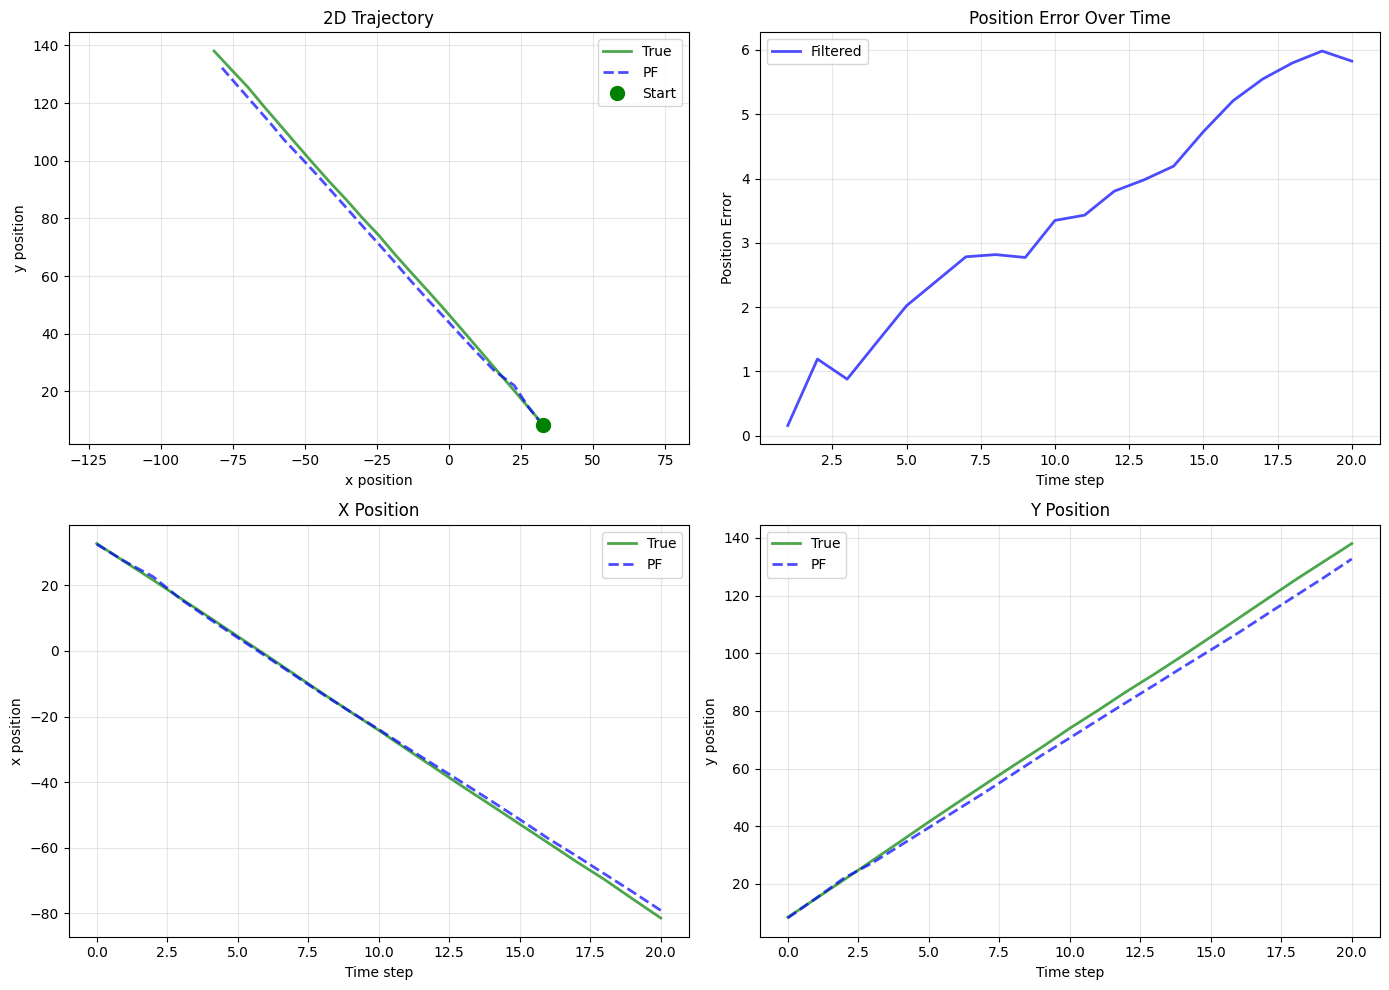

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convert filtered states to numpy for plotting
filtered_np = filtered_states_f32.numpy()
true_np = true_states.numpy()

# 2D Trajectory
ax = axes[0, 0]
ax.plot(true_np[0, :], true_np[2, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(filtered_np[0, :], filtered_np[2, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.plot(true_np[0, 0], true_np[2, 0], 'go', markersize=10, label='Start')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_title('2D Trajectory')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axis('equal')

# Position Error
ax = axes[0, 1]
time_steps = np.arange(1, T+1)
ax.plot(time_steps, pos_error_filtered.numpy(), 'b-', linewidth=2, label='Filtered', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Position Error')
ax.set_title('Position Error Over Time')
ax.grid(True, alpha=0.3)
ax.legend()

# X Position
ax = axes[1, 0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_np[0, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[0, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('x position')
ax.set_title('X Position')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Position
ax = axes[1, 1]
ax.plot(state_time, true_np[2, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[2, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('y position')
ax.set_title('Y Position')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

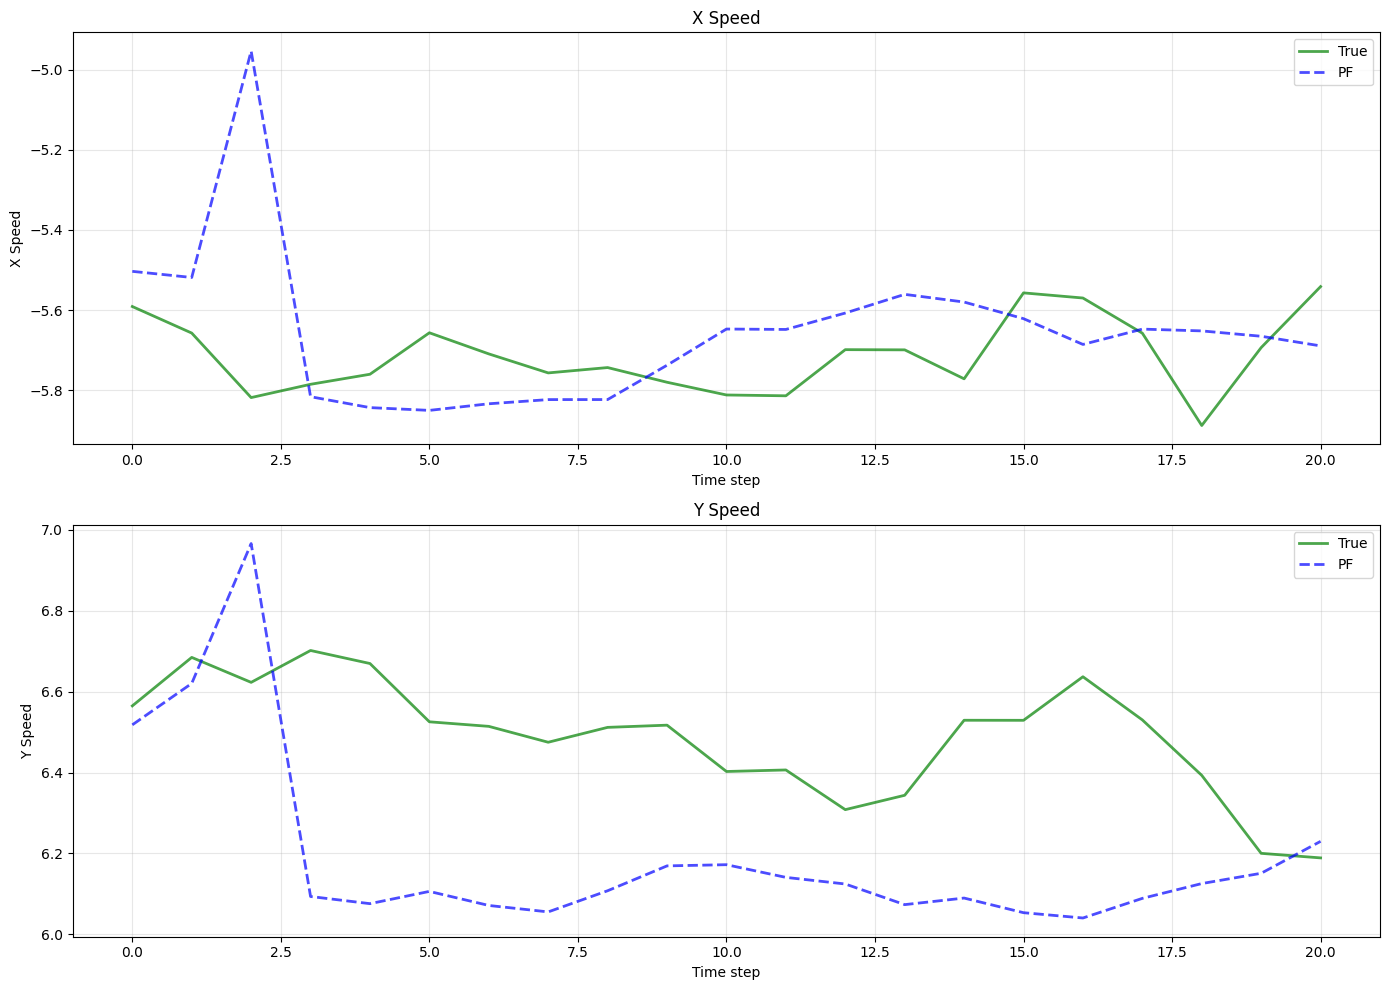

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# X Speed
ax = axes[0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_np[1, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[1, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('X Speed')
ax.set_title('X Speed')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Speed
ax = axes[1]
ax.plot(state_time, true_np[3, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[3, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Y Speed')
ax.set_title('Y Speed')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Visualize Particle Degeneracy

Particle degeneracy occurs when most particle weights become negligible, leaving only a few particles with significant weights. This is monitored using:
- **Effective Sample Size (ESS)**: N_eff = 1 / Σ(w_i²)
- **Weight Distribution**: Visualization of particle weight concentration over time

In [ ]:
def compute_path_degeneracy(ancestry_history):
    """
    Compute a simple path degeneracy measure:
    - For each time t, compute how many distinct ancestors of the
        final generation (time T) are still present at time t.

    Args:
        ancestry_history: Tensor of shape (num_particles, T+1),
            as returned by filter(..., return_details=True).
            ancestry_history[i, t] is the ancestor index at time t-1
            of particle i at time t (with column 0 = [0,1,...,N-1]).

    Returns:
        num_unique_ancestors: Tensor of shape (T+1,),
            where entry t is the number of distinct ancestors at time t
            that lead to the final generation.
    """
    ancestry_history = tf.convert_to_tensor(ancestry_history, dtype=tf.int32)

    # N: number of particles, T+1: number of time steps including t=0
    num_particles = ancestry_history.shape[0]
    T_plus_1 = ancestry_history.shape[1]
    T = T_plus_1 - 1

    # Start from final generation at time T: indices 0..N-1
    ancestors = tf.range(num_particles, dtype=tf.int32)
    num_unique = []

    # Walk backwards in time: T, T-1, ..., 0
    for t in range(T, -1, -1):
        unique_ancestors = tf.unique(ancestors)[0]
        num_unique.append(tf.size(unique_ancestors))

        if t > 0:
            # ancestry_history[:, t] maps particle index at time t
            # to its parent index at time t-1.
            parents_t = ancestry_history[:, t]
            ancestors = tf.gather(parents_t, ancestors)

    # We filled from T -> 0; reverse to get [0, 1, ..., T]
    num_unique = tf.stack(num_unique[::-1])
    return tf.cast(num_unique, tf.float64)


In [11]:
num_unique_ancestors = compute_path_degeneracy(ancestry_history)
print("Number of unique ancestors over time:", num_unique_ancestors.numpy())

Number of unique ancestors over time: [ 1.  1.  1.  1.  1.  1.  1.  1.  2.  3.  3.  5.  5.  5.  6.  7.  7. 17.
 23. 30. 50.]


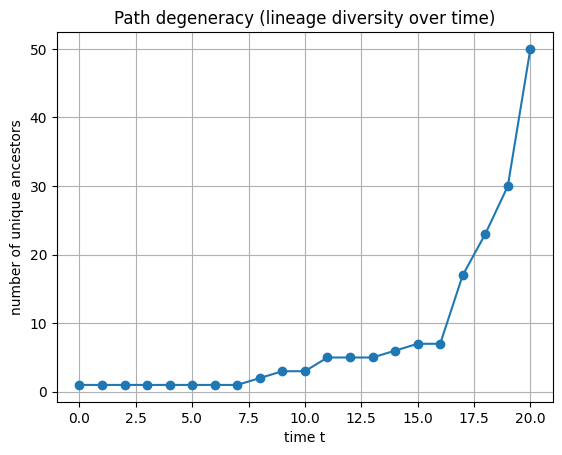

In [12]:
T_plus_1 = num_unique_ancestors.shape[0]
time_axis = tf.range(T_plus_1).numpy()

plt.figure()
plt.plot(time_axis, num_unique_ancestors.numpy(), marker='o')
plt.xlabel('time t')
plt.ylabel('number of unique ancestors')
plt.title('Path degeneracy (lineage diversity over time)')
plt.grid(True)
plt.show()

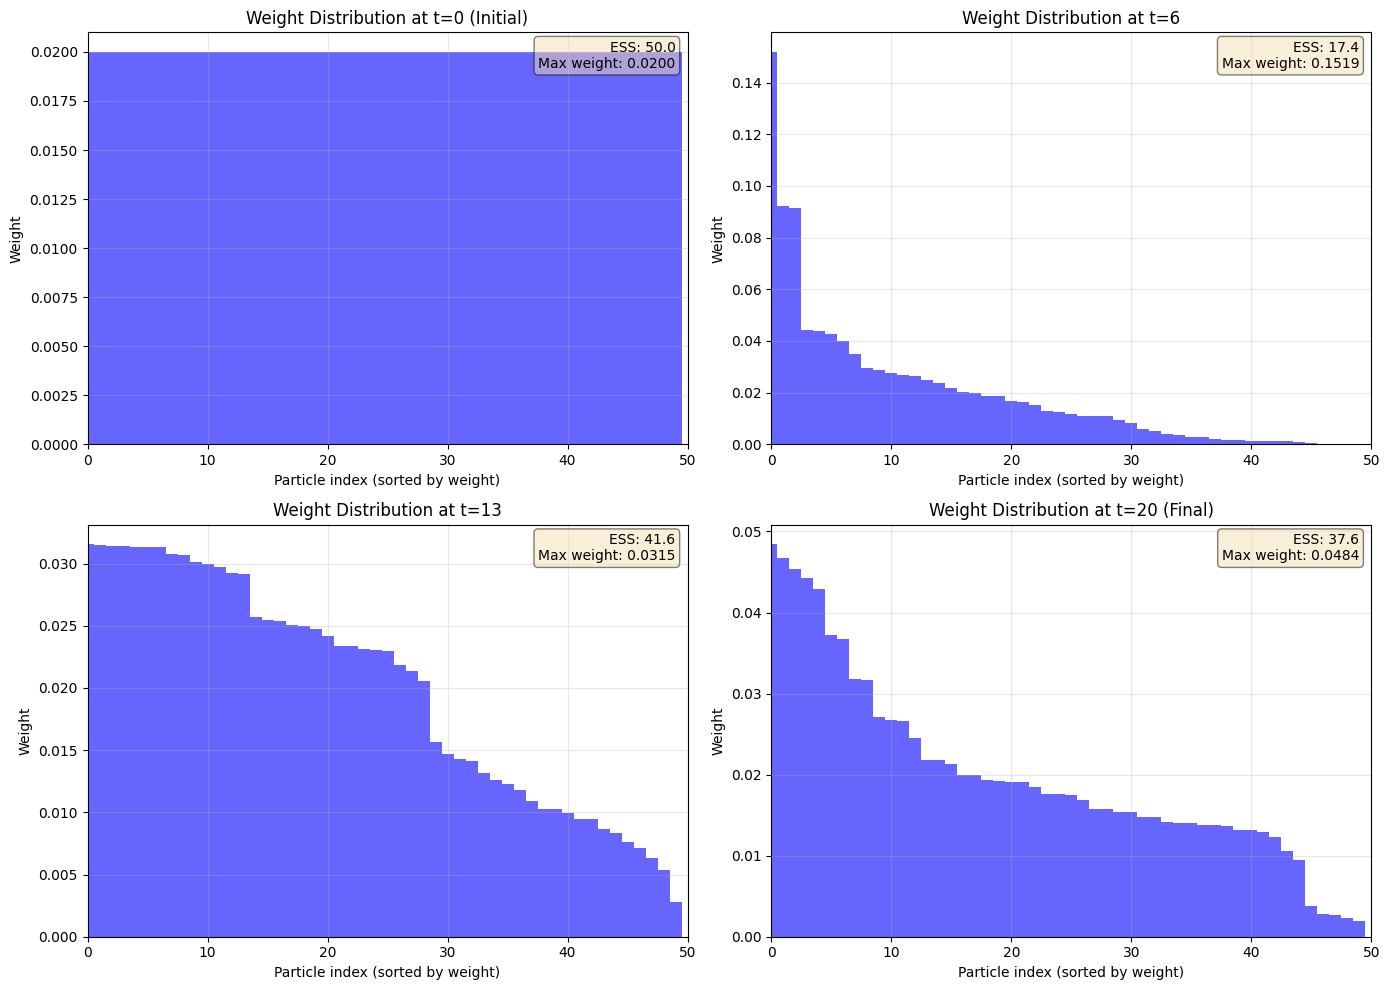

In [15]:
# Visualize weight distribution at different time steps
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Select time steps to visualize
time_indices = [0, T//3, 2*T//3, T]
titles = ['t=0 (Initial)', f't={T//3}', f't={2*T//3}', f't={T} (Final)']

for idx, (t_idx, title) in enumerate(zip(time_indices, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Get weights at this time step
    weights_t = weights_history[:, t_idx].numpy()
    
    # Sort weights in descending order
    sorted_weights = np.sort(weights_t)[::-1]
    
    # Plot weight distribution
    ax.bar(range(len(sorted_weights)), sorted_weights, width=1.0, color='blue', alpha=0.6)
    ax.set_xlabel('Particle index (sorted by weight)')
    ax.set_ylabel('Weight')
    ax.set_title(f'Weight Distribution at {title}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, min(100, pf.num_particles)])  # Show only first 100 particles
    
    # Add statistics
    ess_t = ess_history[t_idx].numpy()
    max_weight = np.max(weights_t)
    ax.text(0.98, 0.98, f'ESS: {ess_t:.1f}\nMax weight: {max_weight:.4f}',
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()